In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "no-latex"])

In [2]:
path_sn = "data_files/sn_data.txt"
path_kp = "data_files/kp_data.txt"

data_sn = pd.read_csv(path_sn)
data_kp = pd.read_csv(path_kp)
data_sn["date"] = pd.to_datetime(data_sn["date"])
data_kp["datetime"] = pd.to_datetime(data_kp["datetime"])
data_kp["date"] = data_kp["datetime"].dt.floor("d")
data_kp = data_kp.drop(columns=["datetime"])
# Sunspot number is counted daily. Kp is measured every three hours.
# Thus, to have the same frequency of both, we take the maximum Kp
# for each day, so that there is only one Kp measurement a day.
data_kp = data_kp.groupby(data_kp["date"]).max().reset_index()
data_merged = data_kp.merge(data_sn)
data_merged_arr = data_merged.loc[:, ["SN", "Kp"]].values

In [3]:
# Commented out data scaling because it somehow seems that the scaling makes the model worse?
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = data_merged_arr#scaler.fit_transform(data_merged_arr)

In [4]:
def create_dataset(data_arr, lookback):
    """Create a dataset with input features, X and target feature y.
    
    The input and target features are generated by taking data from the data_arr in chunks
    of size lookback. If lookback is 7, then each element in X and y will be a week's worth of data.
    The input features and target features are shifted wrt each other by one. So for example, for
    lookback=7, the first element of X will be data_arr[0:7] and for y it will be data_arr[1:8]
    and so on.
    
    Of course, in the above examples, we are only really interested in data_arr[8] as our
    target. The reason we make the target overlapping with X is because some guy on a blogpost claimed
    it was better to do it like this.
    """
    X, y = [], []
    for i in range(len(data_arr)-lookback):
        feature = data_arr[i:i+lookback]
        target = data_arr[i+1:i+lookback+1, -1]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(-1)


In [5]:
lookback = 7
train_frac = 0.7
train_size = int(len(data_scaled) * train_frac)
train = data_scaled[:train_size]
test = data_scaled[train_size:]

In [6]:
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([3573, 7, 2]) torch.Size([3573, 7, 1])
torch.Size([1528, 7, 2]) torch.Size([1528, 7, 1])


In [7]:
class SunModelLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers): 
        super(SunModelLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [8]:
input_size = 2
hidden_size = 50
num_layers = 5
batch_size = 32

In [9]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [10]:
def train_valid(n_epochs, model, optimizer, loss_fn, train_loader, test_loader, device):
    train_hist = []
    test_hist = []

    # Training loop
    for epoch in range(n_epochs):
        total_loss = 0.0
    
        # Training
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_y)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
        # Calculate average training loss and accuracy
        average_loss = total_loss / len(train_loader)
        train_hist.append(average_loss)
    
        # Validation on test data
        model.eval()
        with torch.no_grad():
            total_test_loss = 0.0
    
            for batch_X_test, batch_y_test in test_loader:
                batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                predictions_test = model(batch_X_test)
                test_loss = loss_fn(predictions_test, batch_y_test)
    
                total_test_loss += test_loss.item()
    
            # Calculate average test loss and accuracy
            average_test_loss = total_test_loss / len(test_loader)
            test_hist.append(average_test_loss)
        if (epoch+1)%10==0:
            print(f'Epoch [{epoch+1}/{n_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')
    return train_hist, test_hist    

In [11]:
n_epochs = 50
loss_fn = nn.MSELoss(reduction='mean')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SunModelLSTM(input_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=1e-4/2)
model.to(device)

SunModelLSTM(
  (lstm): LSTM(2, 50, num_layers=5, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [12]:
train_hist, test_hist = train_valid(n_epochs, model, optimizer, loss_fn, train_loader, test_loader, device)

Epoch [10/50] - Training Loss: 2.1188, Test Loss: 2.0636
Epoch [20/50] - Training Loss: 1.7697, Test Loss: 1.7778
Epoch [30/50] - Training Loss: 1.7442, Test Loss: 1.7584
Epoch [40/50] - Training Loss: 1.7426, Test Loss: 1.7560
Epoch [50/50] - Training Loss: 1.7410, Test Loss: 1.7560


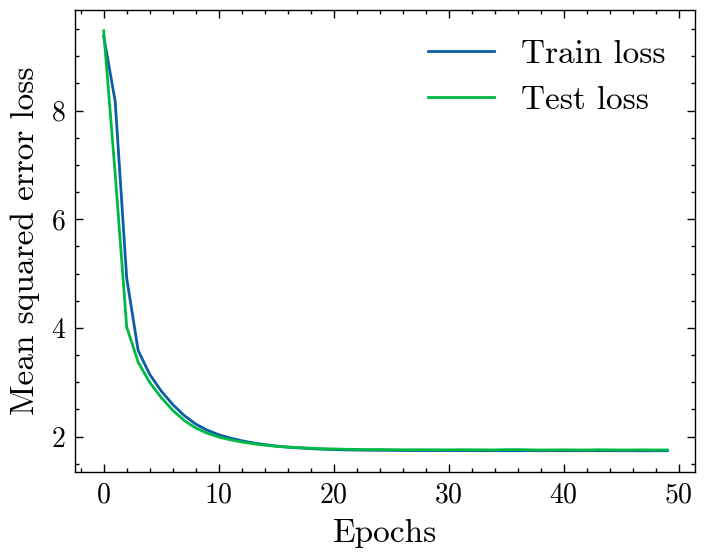

In [16]:
plt.figure(figsize=(4, 3), dpi=200)
plt.plot(train_hist, label="Train loss")
plt.plot(test_hist, label="Test loss")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Mean squared error loss", fontsize=12)
plt.legend(fontsize=12)

In [17]:
def make_pred1(X_test, n_week, num_forecast_steps, lookback):
    """Predict num_forecast_steps days in the future based on the n_week(-th) week
    in the test dataset.

    The way the prediction is made is as follows. Assume that lookback is 7,
    like before. Then, we are inputting the first n_weeks weeks of the test dataset
    and trying to predict num_forecast_steps days in the future, based on that.

    We start making a prediction based on historical_data. historical_data is just the
    first n_weeks weeks of the test dataset, initially. Then, we take the first (zero-index)
    element of the predicted values. For the first iteration, this will just be the predicted
    Kp of the first day of the first week in the test dataset, which is a value that we of
    course already know. Then, we update historical_data by removing the first element and
    appending the most recent prediction on to the end. Because we also make predictions on
    elements we already have, we don't ust repeat this process num_forecast_steps times,
    but num_forecast_steps + n_weeks*lookback times instead.

    As to why we do the forecasting by re-predicting values we already know the
    ground truth for and forecasting based on those predictions, the answer is as before.
    Some guy online did it like this.
    """
    sequence_to_plot = X_test.squeeze().cpu().numpy()
    # Predict based on the first chunk (week for lookback=7) in the test set
    historical_data = sequence_to_plot[n_week]
    forecasted_values = []
    with torch.no_grad():
        for _ in range(num_forecast_steps+lookback):
            historical_data_tensor = torch.as_tensor(historical_data).float().to(device)
            predicted_value = model(historical_data_tensor).cpu().numpy()[0]
            forecasted_values.append(predicted_value[0])

            historical_data = np.roll(historical_data, shift=-1)
            historical_data[-1] = predicted_value
    return forecasted_values

In [18]:
num_forecast_steps = 8
n_week = 4
forecasted_vals = make_pred1(X_test, n_week, num_forecast_steps, lookback)
# forecasted_vals = scaler.inverse_transform(np.stack((np.arange(len(forecasted_vals)), forecasted_vals)).T)[:, 1]
true_start = n_week + lookback
true_data = test[true_start:true_start + num_forecast_steps]
# true_data = scaler.inverse_transform(true_data)[:, 1]

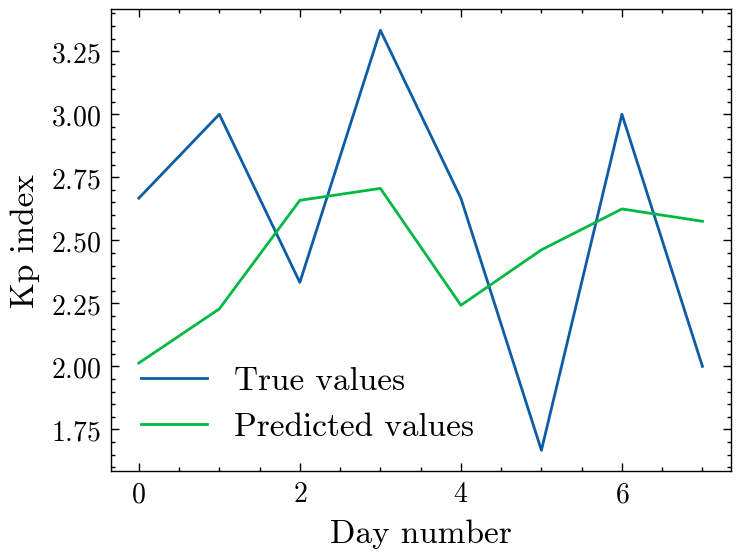

In [20]:
plt.figure(figsize=(4, 3), dpi=200)
plt.plot(true_data[:, 1], label="True values")
plt.plot(forecasted_vals[lookback:], label="Predicted values")
plt.xlabel("Day number", fontsize=12)
plt.ylabel("Kp index", fontsize=12)
plt.legend(fontsize=12)